# Linear Regression, KNN, LGBM, XGB, Random Forest, SVR/Linear-SVR  - <br /> by Jerome, 03 December2021 #

---

In [1]:
## load modules
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from modeling.functions import modelling, log_to_mlflow, get_features, baseline, modelling_fc 
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.neighbors import KNeighborsRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import pickle 
import ast 


RSEED = 42


/Users/jeromesauer/neuefische/Capstone_WindPowerPredicting/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### Read data, remove NaNs and get dummies for cardinal wind directions ###

In [2]:
## read data
data = pd.read_csv('../data/GEFCom2014Data/Wind/raw_data_incl_features.csv', parse_dates=['TIMESTAMP'], index_col='TIMESTAMP')
data.interpolate(method='linear', inplace=True)
data = pd.get_dummies(data, columns = ['WD100CARD','WD10CARD'], drop_first=True)
data.info()
data.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175440 entries, 2012-01-01 01:00:00 to 2014-01-01 00:00:00
Data columns (total 46 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ZONEID         175440 non-null  int64  
 1   TARGETVAR      175440 non-null  float64
 2   U10            175440 non-null  float64
 3   V10            175440 non-null  float64
 4   U100           175440 non-null  float64
 5   V100           175440 non-null  float64
 6   HOUR           175440 non-null  int64  
 7   MONTH          175440 non-null  int64  
 8   WEEKDAY        175440 non-null  int64  
 9   IS_HOLIDAY     175440 non-null  int64  
 10  WS10           175440 non-null  float64
 11  WS100          175440 non-null  float64
 12  WD10           175440 non-null  float64
 13  WD100          175440 non-null  float64
 14  U100NORM       175440 non-null  float64
 15  V100NORM       175440 non-null  float64
 16  WD100CARD_ENE  175440 non-null  uint8  


,ZONEID,TARGETVAR,U10,V10,U100,V100,HOUR,MONTH,WEEKDAY,IS_HOLIDAY,...,WD10CARD_NNW,WD10CARD_NW,WD10CARD_S,WD10CARD_SE,WD10CARD_SSE,WD10CARD_SSW,WD10CARD_SW,WD10CARD_W,WD10CARD_WNW,WD10CARD_WSW
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2012-01-01 01:00:00,1,0.000000,2.124600,-2.681966,2.864280,-3.666076,1,1,6,1,...,0,1,0,0,0,0,0,0,0,0
2012-01-01 02:00:00,1,0.054879,2.521695,-1.796960,3.344859,-2.464761,2,1,6,1,...,0,1,0,0,0,0,0,0,0,0
2012-01-01 03:00:00,1,0.110234,2.672210,-0.822516,3.508448,-1.214093,3,1,6,1,...,0,0,0,0,0,0,0,0,1,0
2012-01-01 04:00:00,1,0.165116,2.457504,-0.143642,3.215233,-0.355546,4,1,6,1,...,0,0,0,0,0,0,0,1,0,0
2012-01-01 05:00:00,1,0.156940,2.245898,0.389576,2.957678,0.332701,5,1,6,1,...,0,0,0,0,0,0,0,1,0,0


### Train-test-split, get different combinations of features and run different models with them ###

In [3]:
## train-test-split and get features and zones
data_train = data[:'2013-07-01 00:00:00']
data_test = data['2013-07-01 01:00:00':]
feature_dict = get_features(data)

In [4]:
# ## run different models and save scores in csv file
#models = [LGBMRegressor(random_state=RSEED)]
#models = [KNeighborsRegressor()]
models = [LinearRegression()]

for model in models:

    # Baseline
    if model == 'Baseline':
        with open(f'../results/{model}.pkl','rb') as fin:
            df = pickle.load(fin)
            df.rename(columns = {'model':'MODEL', 'zone':'ZONE', 'bestparams':'BEST_PARAMS', 'test_score':'TESTSCORE', 'train_score':'TRAINSCORE'}, inplace=True)
            df['CV'] = np.nan
            results = df.drop('features', axis=1)

    # RandomForest
    if model.__class__.__name__ == 'RandomForestRegressor':
        param_grid = {'n_estimators' : [100,150], 'max_depth' : np.arange(15,31,5), 'min_samples_leaf' : np.arange(10,21,10)}
        results = modelling_fc(data_train, data_test, feature_dict, model, param_grid = param_grid, scaler=MinMaxScaler(), n_jobs=3)

    # Linear regression
    if model.__class__.__name__ == 'LinearRegression':
        param_grid = {'fit_intercept' : [True]}
        results = modelling_fc(data_train, data_test, feature_dict, model, param_grid = param_grid, scaler=MinMaxScaler(), n_jobs=-1)

    # XGBoost
    if model.__class__.__name__ == 'XGBRegressor':
        param_grid = {'random_state' : [RSEED]}
        results = modelling_fc(data_train, data_test, feature_dict, model, param_grid = param_grid, scaler = MinMaxScaler(), n_jobs=-1)

    # LGBM
    if model.__class__.__name__ == 'LGBMRegressor':
        param_grid = [{'n_estimators' : [100]},
                      {'n_estimators' : [1000], 'num_leaves' : [20]},
                      {'n_estimators' : [50], 'num_leaves': [62]}]
        results = modelling_fc(data_train, data_test, feature_dict, model, param_grid = param_grid, scaler = MinMaxScaler(), n_jobs=-1)

    # KNN
    if model.__class__.__name__ == 'KNeighborsRegressor': 
        param_grid = {'n_neighbors' : np.arange(20,141,10), 'weights' : ['uniform','distance'], 'p' : [1,2]}
        results = modelling_fc(data_train, data_test, feature_dict, model, scaler = MinMaxScaler(), param_grid = param_grid)

    # remove file before new file is created
    if os.path.isfile(f'../results/{results.MODEL.iloc[1]}.csv'):
        os.remove(f'../results/{results.MODEL.iloc[1]}.csv')

    # save results in csv file
    results.to_csv(f'../results/{results.MODEL.iloc[1]}.csv')

Total number of fits: 400
feature combination: all

Scaler: MinMaxScaler
Scaled X_train min/max: 0.0, 1.0
Scaled X_test min/max: -0.0, 1.0

ZONEID 1
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/jeromesauer/neuefische/Capstone_WindPowerPredicting/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/jeromesauer/neuefische/Capstone_WindPowerPredicting/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/jeromesauer/neuefische/Capstone_WindPowerPredicting/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/jeromesauer/neuefische/Capstone_WindPowerPredicting/.venv/lib/python3.9/site-packages/pandas/compat/__init__

[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END .................................fit_intercept=True; total time=   0.0s
Scaler: MinMaxScaler
Scaled X_train min/max: 0.0, 1.0
Scaled X_test min/max: -0.01, 1.0

ZONEID 2
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END .................................fit_intercept=True; total time=   0.0s


/Users/jeromesauer/neuefische/Capstone_WindPowerPredicting/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


[CV] END .................................fit_intercept=True; total time=   0.0s
Scaler: MinMaxScaler
Scaled X_train min/max: 0.0, 1.0
Scaled X_test min/max: -0.06, 1.08

ZONEID 3
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END .................................fit_intercept=True; total time=   0.0s


/Users/jeromesauer/neuefische/Capstone_WindPowerPredicting/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/jeromesauer/neuefische/Capstone_WindPowerPredicting/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END .................................fit_intercept=True; total time=   0.0s
Scaler: MinMaxScaler
Scaled X_train min/max: 0.0, 1.0
Scaled X_test min/max: -0.02, 1.09

ZONEID 4
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END .................................fit_intercept=True; total time=   0.0s
Scaler: MinMaxScaler
Scaled X_train min/max: 0.0, 1.0
Scaled X_test min/max: -0.02, 1.09

ZONEID 5
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END ...........................

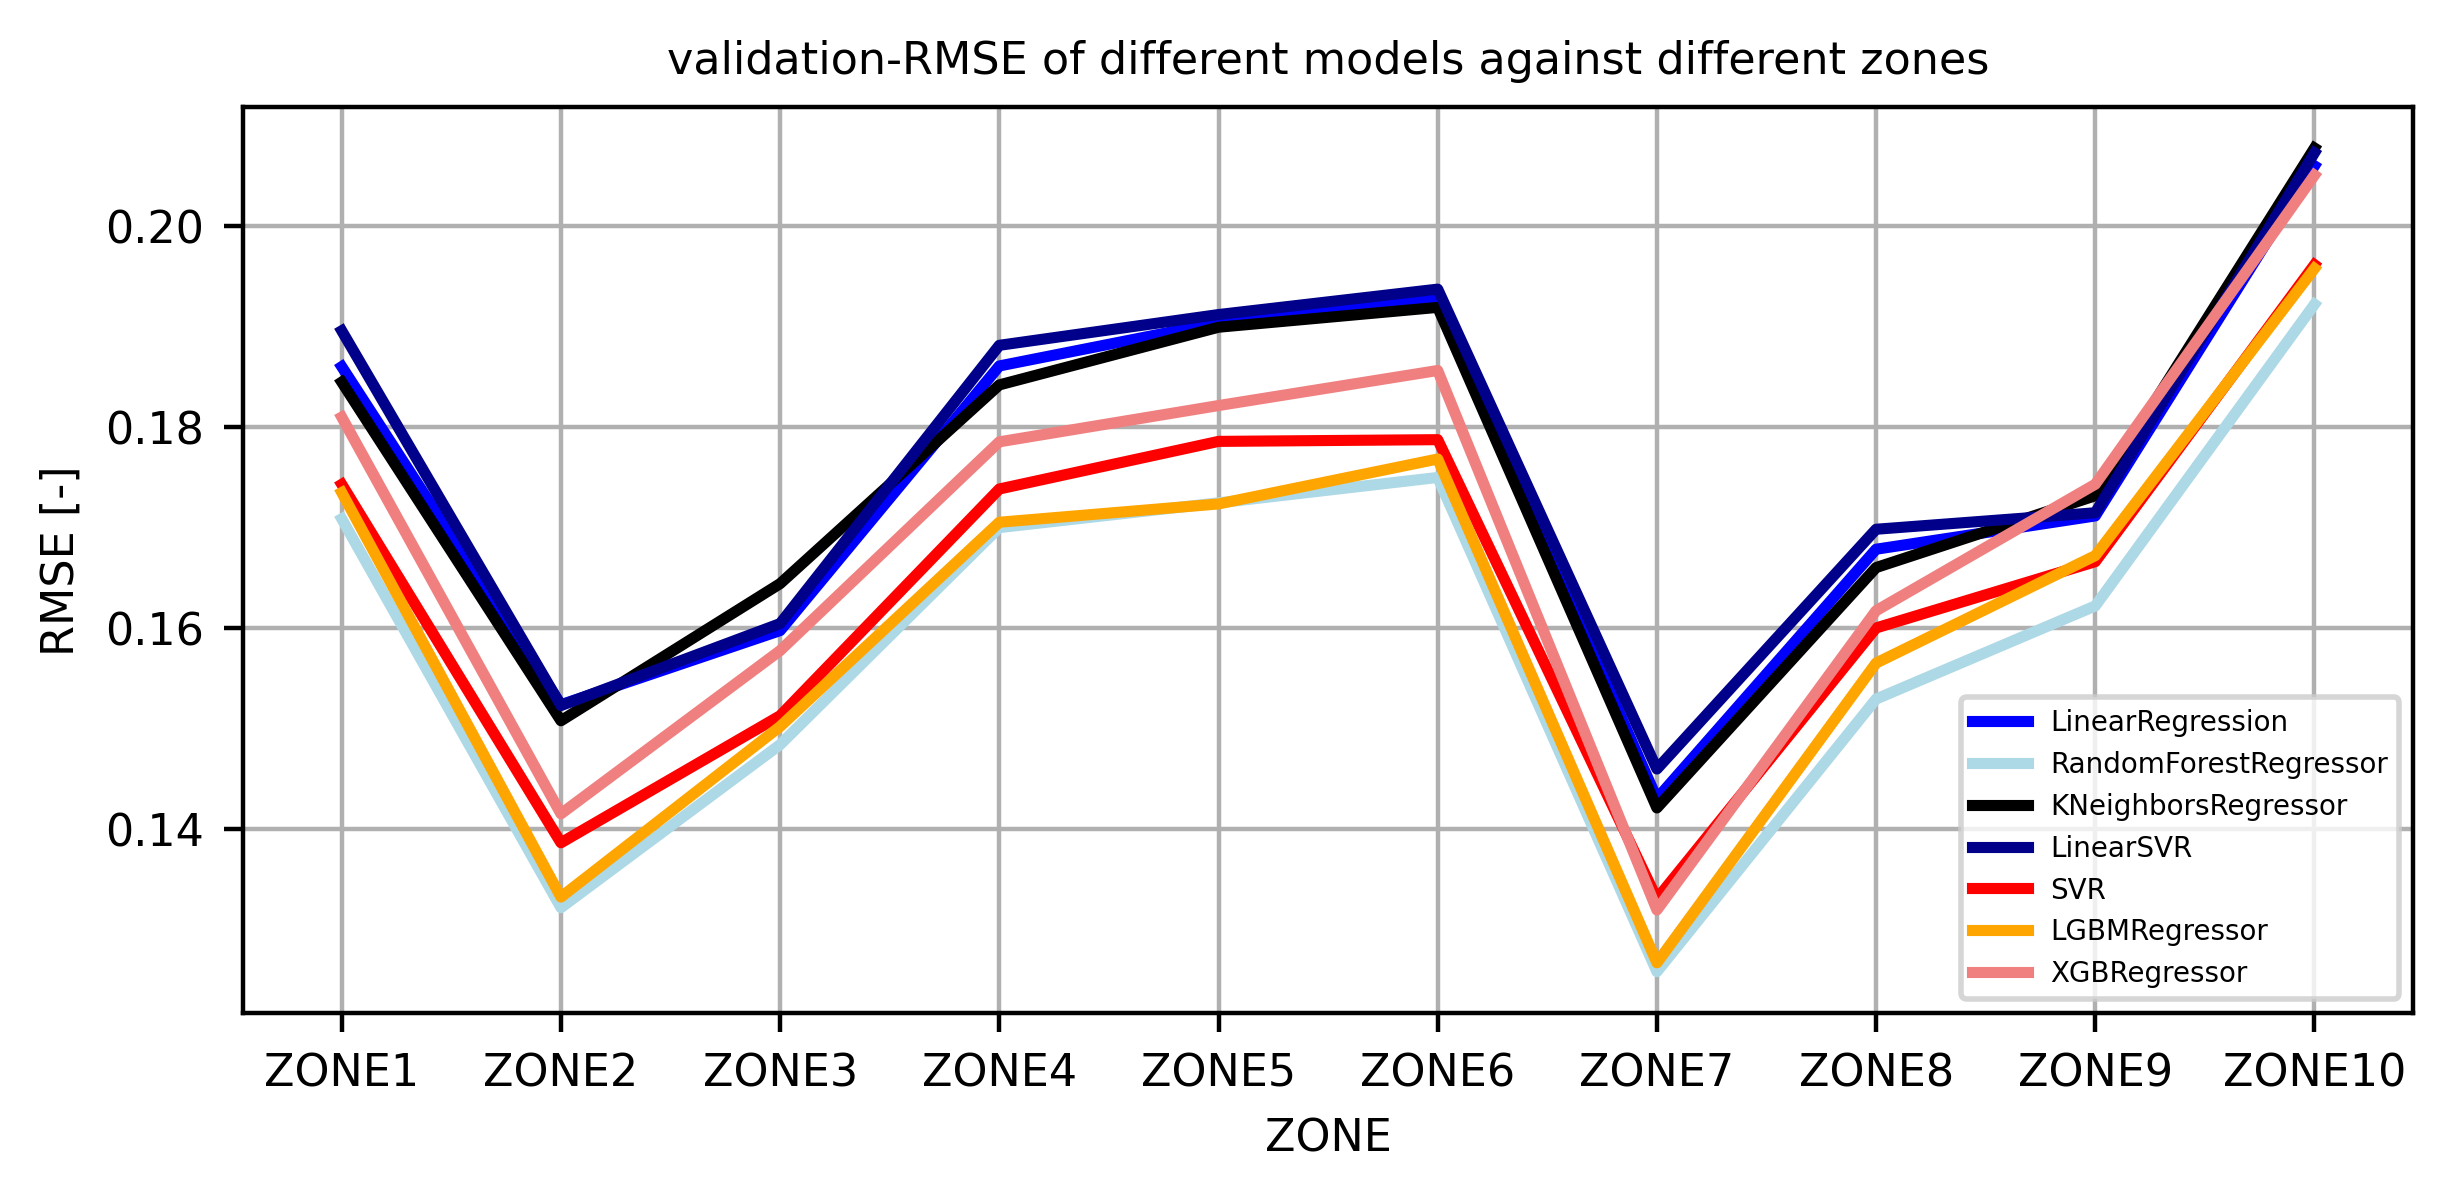

In [11]:
## plot RMSE for different models (best feature combination) against different zones
models = ['LinearRegression', 'RandomForestRegressor', 'KNeighborsRegressor', 'LinearSVR', 'SVR', 'LGBMRegressor', 'XGBRegressor']

linewidth, fontsize = 2, 8
colors = ['b','lightblue','k','darkblue','r', 'orange', 'lightcoral']
fig, ax = plt.subplots(dpi=400, figsize=(7,3))

for i,model in enumerate(models):
    df = pd.read_csv(f'../results/{model}.csv', index_col='ZONE')
    ax.plot(df.index, df.CV, color = colors[i], linewidth=linewidth)

ax.grid()
ax.tick_params(labelsize=fontsize)
ax.set_ylabel('RMSE [-]', fontsize=fontsize)
ax.set_xlabel('ZONE', fontsize=fontsize)

ax.legend(['{}'.format(model) for model in models], fontsize = fontsize-3)
ax.set_title('validation-RMSE of different models against different zones', fontsize=fontsize);

fig.savefig('../images/VAL-RMSE_ZONES.png')

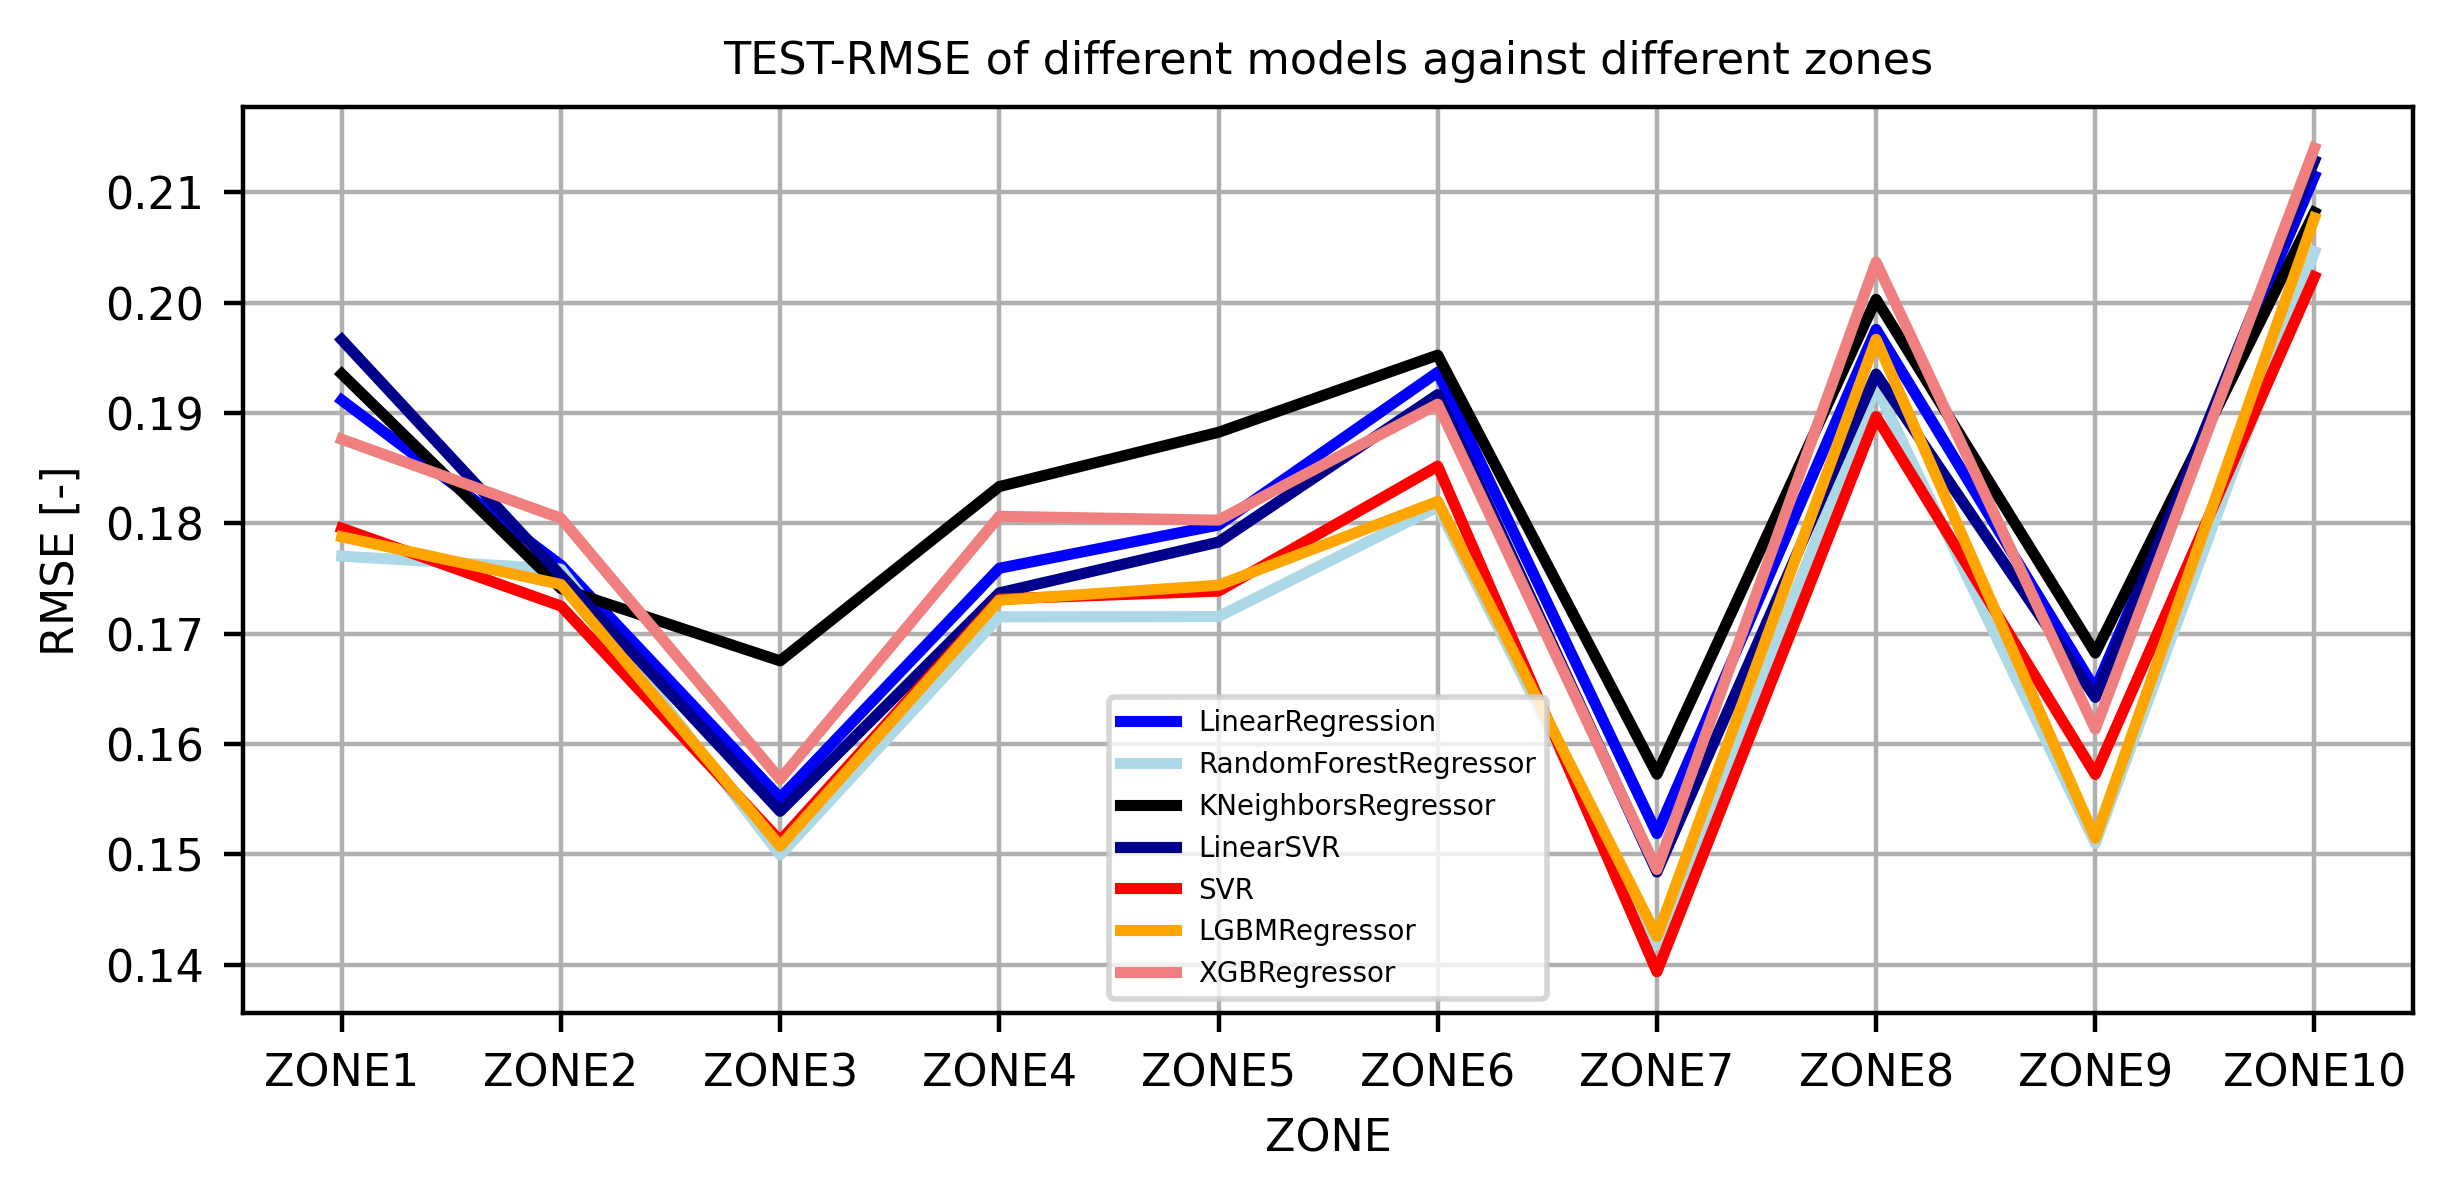

In [12]:
## plot RMSE for different models (best feature combination) against different zones
models = ['LinearRegression', 'RandomForestRegressor', 'KNeighborsRegressor', 'LinearSVR', 'SVR', 'LGBMRegressor', 'XGBRegressor']

linewidth, fontsize = 2, 8
colors = ['b','lightblue','k','darkblue','r', 'orange', 'lightcoral']
fig, ax = plt.subplots(dpi=400, figsize=(7,3))

for i,model in enumerate(models):
    df = pd.read_csv(f'../results/{model}.csv', index_col='ZONE')
    ax.plot(df.index, df.TESTSCORE, color = colors[i], linewidth=linewidth)

ax.grid()
ax.tick_params(labelsize=fontsize)
ax.set_ylabel('RMSE [-]', fontsize=fontsize)
ax.set_xlabel('ZONE', fontsize=fontsize)

ax.legend(['{}'.format(model) for model in models], fontsize = fontsize-3)
ax.set_title('TEST-RMSE of different models against different zones', fontsize=fontsize);

fig.savefig('../images/TEST-RMSE_ZONES.png')

In [6]:
models = ['Baseline','LinearRegression', 'KNeighborsRegressor', 'RandomForestRegressor','LinearSVR', 'SVR', 'LGBMRegressor', 'XGBRegressor']

total = pd.DataFrame(index = models, columns = ['TESTSCORE','VALSCORE'])

for model in models:
    df = pd.read_csv(f'../results/{model}.csv', index_col='ZONE')
    if model != 'Baseline':
        total.loc[model]['TESTSCORE'] = np.sqrt(np.mean(df.TESTSCORE**2))
        total.loc[model]['VALSCORE'] = np.sqrt(np.mean(df.CV**2))
    else:
        total.loc[model]['TESTSCORE'] = df.loc['TOTAL'].TESTSCORE

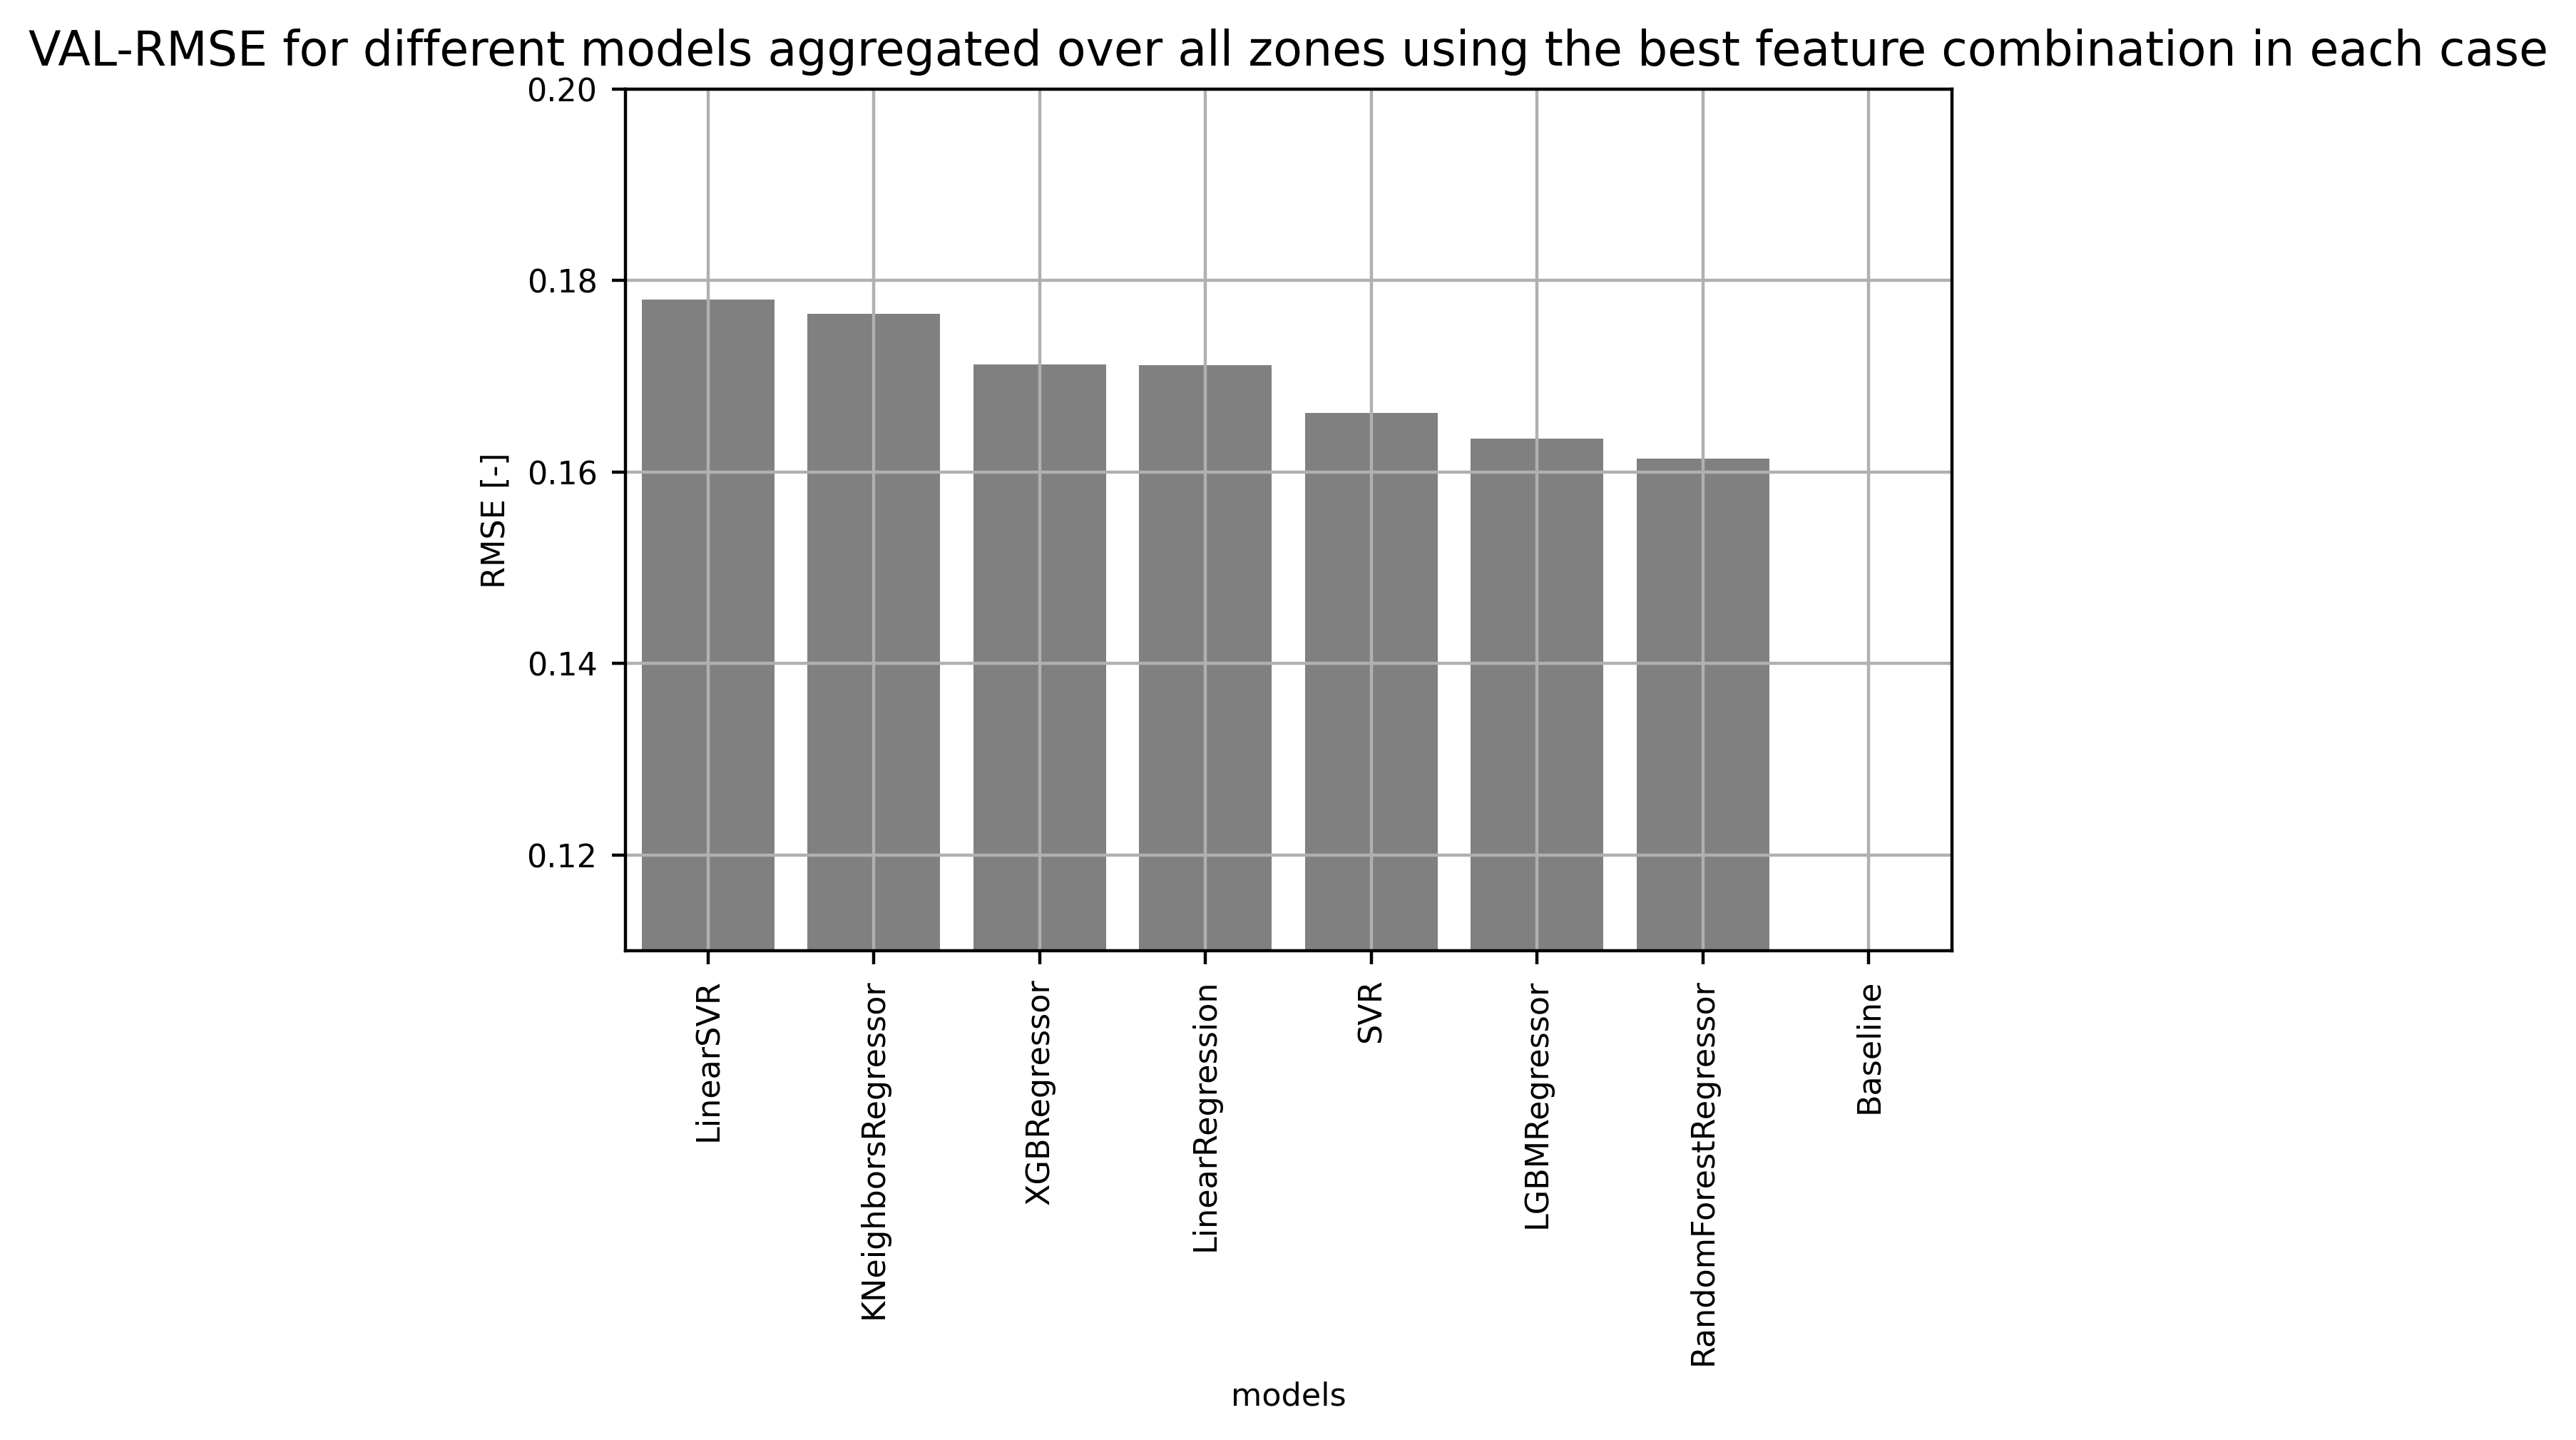

In [8]:
fontsize=8
total = total.sort_values(by='VALSCORE', ascending=False)
fig, ax = plt.subplots(dpi=400)
sns.barplot(data = total, x = total.index, y = 'VALSCORE', color = 'gray', ax=ax)
ax.grid()
ax.set_xlabel('models', fontsize=fontsize)
ax.set_ylabel('RMSE [-]', fontsize=fontsize)
ax.tick_params(axis='both', labelsize=fontsize) 
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
ax.set_ylim([.11,.20])
ax.set_title('VAL-RMSE for different models aggregated over all zones using the best feature combination in each case');

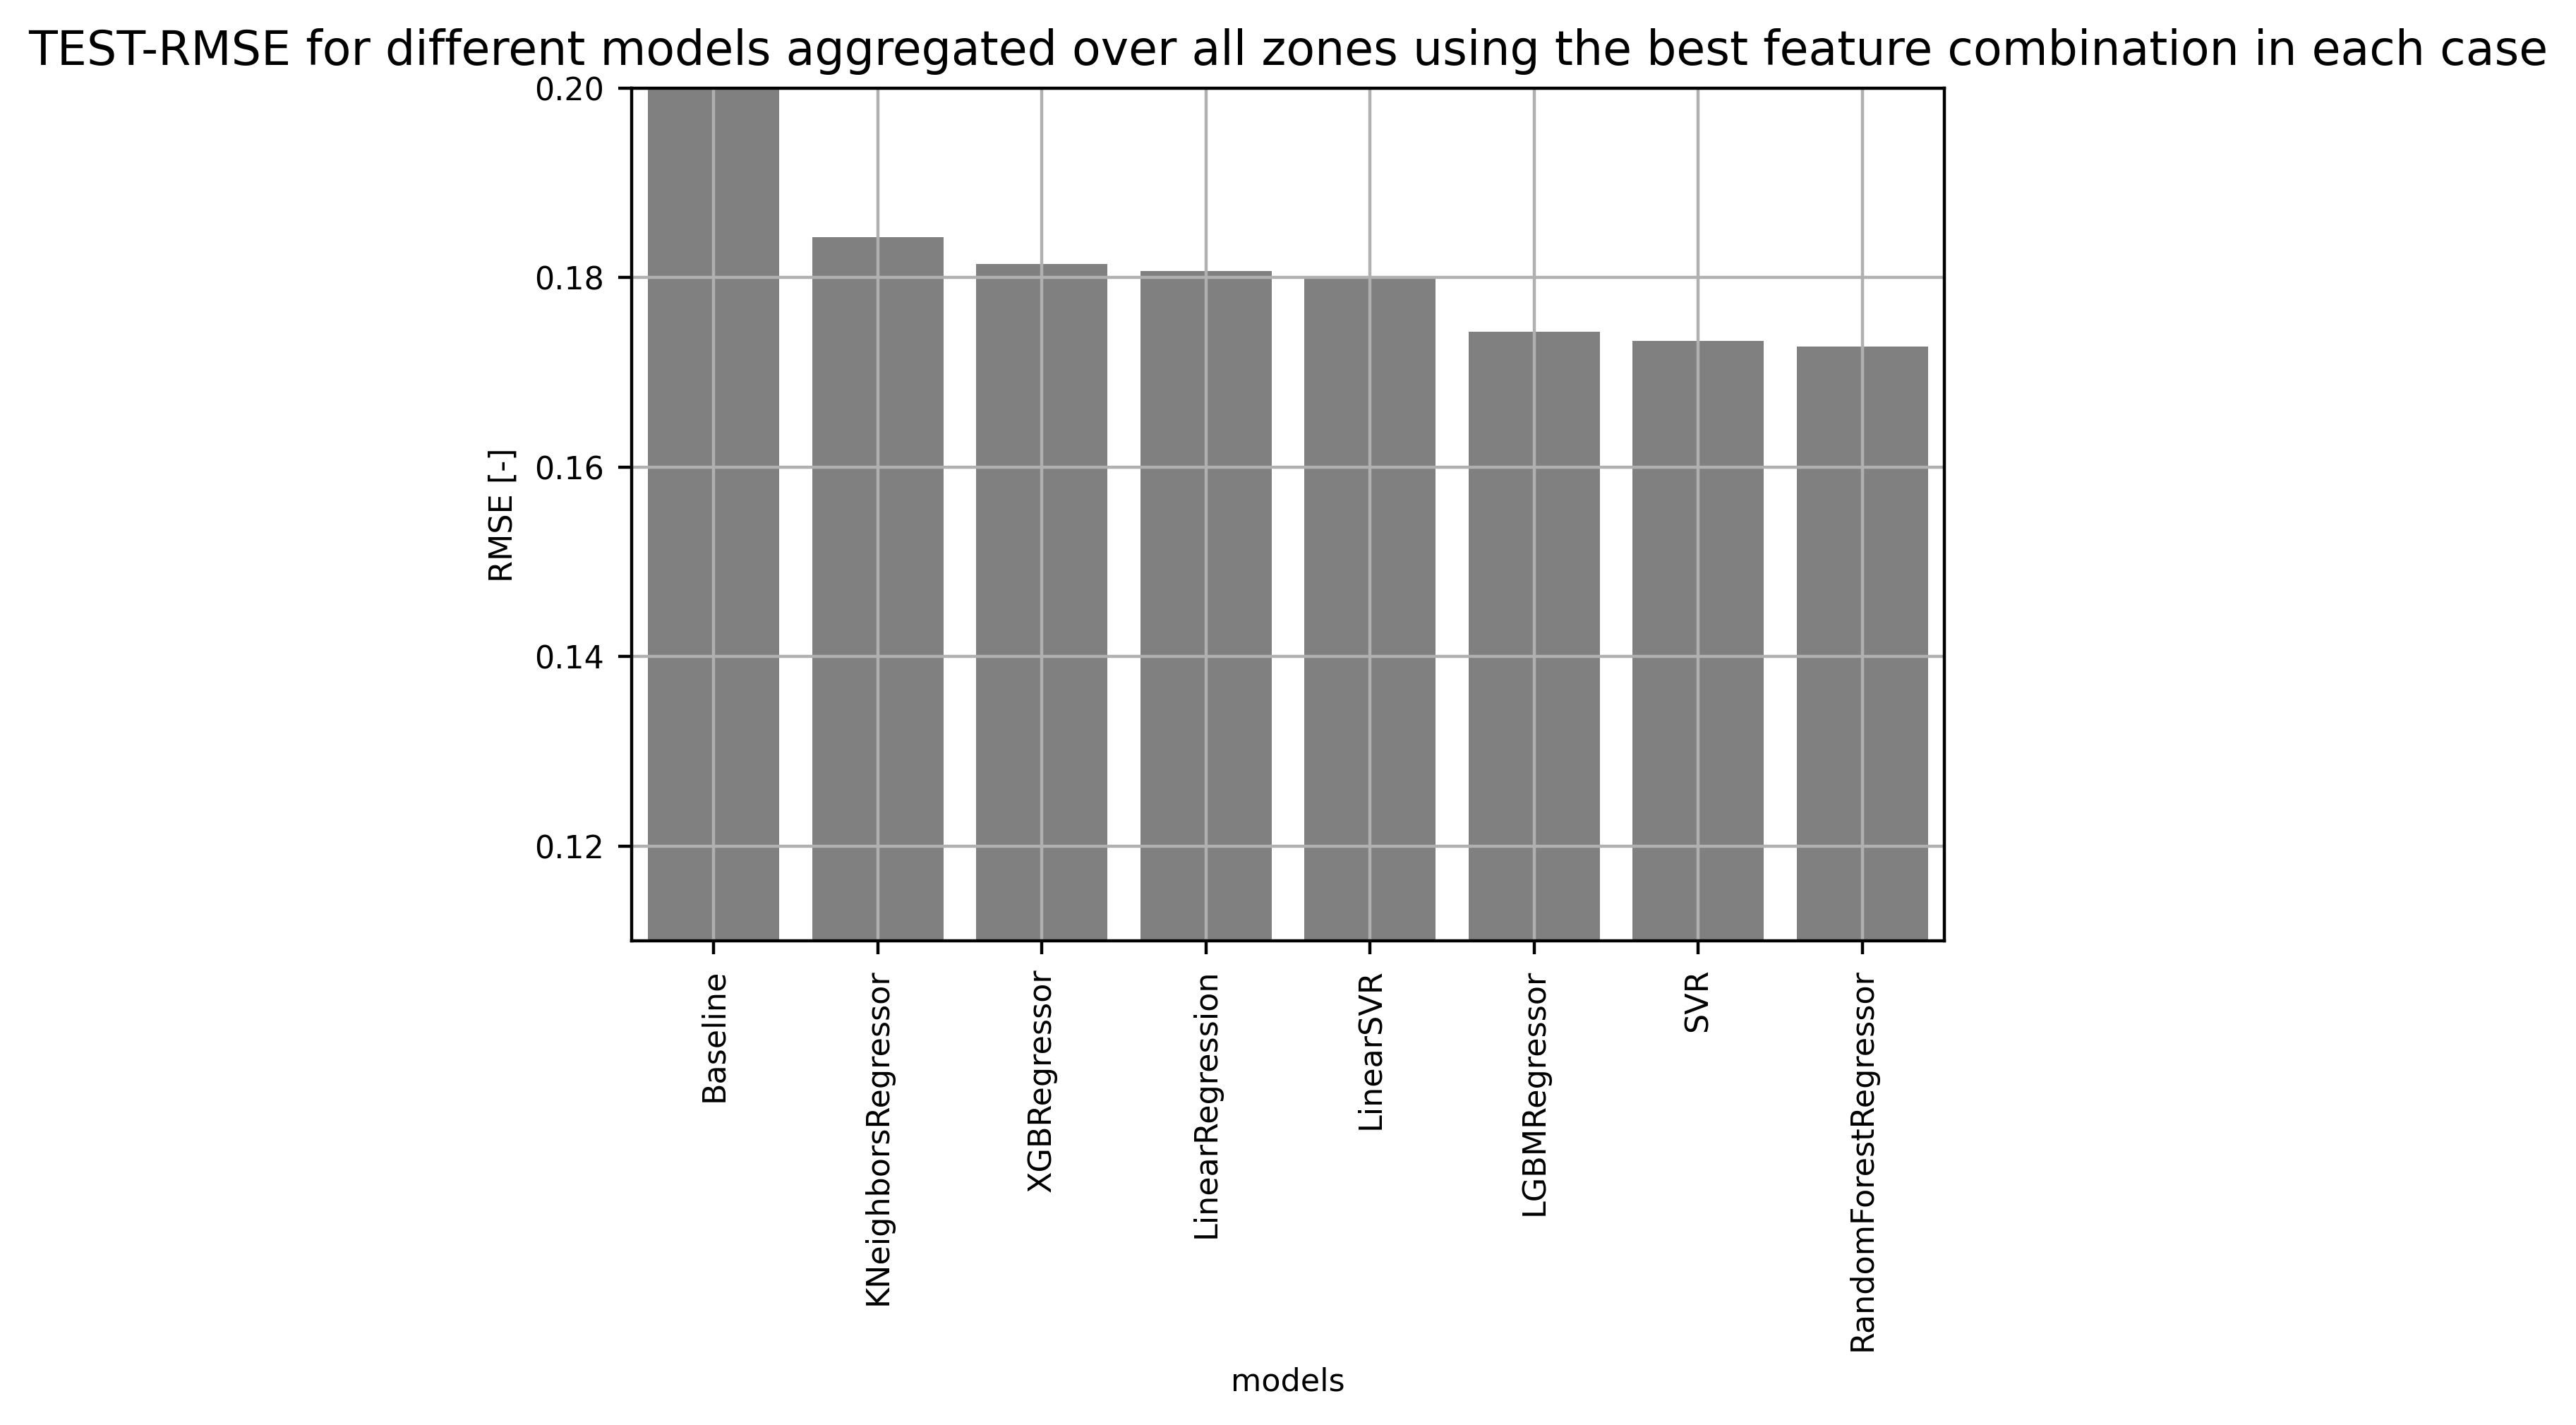

In [9]:
total = total.sort_values(by='TESTSCORE', ascending=False)
fig, ax = plt.subplots(dpi=400)
sns.barplot(data = total, x = total.index, y = 'TESTSCORE', color = 'gray', ax=ax)
ax.grid()
ax.set_xlabel('models', fontsize=fontsize)
ax.set_ylabel('RMSE [-]', fontsize=fontsize)
ax.tick_params(axis='both', labelsize=fontsize) 
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
ax.set_ylim([.11,.20])
ax.set_title('TEST-RMSE for different models aggregated over all zones using the best feature combination in each case');

In [ ]:
#total = total.sort_values(by='TESTSCORE', ascending=False)